# BundleFlow Colab Demo

**🎯 Rectified Flow–based menus for combinatorial auctions**

このノートブックでは、BundleFlowの新しいAPI構造を使用して、組み合わせオークションのためのメニュー最適化をデモンストレーションします。

## 📋 目次
1. [環境セットアップ](#setup)
2. [新しいAPI構造のデモ](#api-demo)
3. [Stage1: Flow初期化](#stage1)
4. [Stage2: Menu最適化](#stage2)
5. [結果の可視化](#visualization)

## 1. 環境セットアップ

まず、GPU環境を確認し、必要なパッケージをインストールします。

In [1]:
!nvidia-smi

Sun Oct 12 08:04:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install omegaconf tqdm numpy matplotlib seaborn

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
# PyTorchとCUDAの確認
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 42.5 GB


In [21]:
%pip install -e ./bundle-flow

[Errno 2] No such file or directory: '/content/drive/MyDrive'
/content
Obtaining file:///content/bundle-flow
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for bundleflow (pyproject.toml) ... done
  Created wheel for bundleflow: filename=bundleflow-0.1.0-0.editable-py3-none-any.whl size=5381 sha256=1475c877764ac42d2261509be3ab4900998639df1703eafc034c471dab2a09e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-z6xtr7f5/wheels/aa/0d/ef/86434bfad24a089645d92e86964593aa2e3dc3368bcd8ec59f
Successfully built bundleflow
  Attempting uninstall: bundleflow
    Found existing installation: bundleflow 0.1.0
    Uninstalling bundleflow-0.1.0:
      Successfully uninstalled bundleflow-0.1.0


In [17]:
%ls ./bundle-flow

bundleflow/           CITATION.cff          Makefile        RegretNet.ipynb
bundleflow.egg-info/  COLAB_SETUP_GUIDE.md  MODEL.md        src/
BundleFlow.ipynb      conf/                 pyproject.toml  tests/
checkpoints/          LICENSE               README.md       tools/


## 2. 新しいAPI構造のデモ

BundleFlowの新しいAPI構造を紹介します。

In [9]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
%cd /content/bundle-flow

/content/bundle-flow


In [28]:
import sys
sys.path.append('/content/bundle-flow/bundleflow')

In [29]:
# BundleFlowの新しいAPI
from bundleflow.models.flow import BundleFlow
from bundleflow.models.menu import MenuElement, Mechanism
from bundleflow.valuation.valuation import XORValuation

print("✅ 新しいAPI構造のインポートが完了しました")
print(f"PyTorch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✅ 新しいAPI構造のインポートが完了しました
PyTorch device: cuda


In [30]:
# 基本的なAPIのデモンストレーション
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. BundleFlow（速度場ネットワーク）の作成
m = 10  # 商品数
flow = BundleFlow(m=m).to(device)
print(f"✅ BundleFlow created with m={m}")

# 2. 速度場の計算
x = torch.randn(3, m, device=device)
t = torch.rand(3, device=device)
v = flow.velocity(x, t)
print(f"✅ Velocity field shape: {v.shape}")

# 3. MenuElement（メニュー要素）の作成
D = 5  # 初期分布の混合成分数
elem = MenuElement(m=m, D=D).to(device)
price = elem.price()
print(f"✅ MenuElement created with price: {price.item():.4f}")

# 4. XORValuation（評価関数）の作成
atoms = [([1, 2, 3], 5.0), ([4, 5], 3.0), ([6, 7, 8, 9], 8.0)]
valuation = XORValuation.from_bundle_list(m, atoms)
bundle = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0])
value = valuation.value(bundle)
print(f"✅ XORValuation value: {value:.4f}")

Using device: cuda
✅ BundleFlow created with m=10
✅ Velocity field shape: torch.Size([3, 10])
✅ MenuElement created with price: 0.1892
✅ XORValuation value: 8.0000


## 3. Stage1: Flow初期化

速度場ネットワークを学習して、連続変数から離散束への変換を学習します。

In [32]:
# Stage1の設定（小規模でデモ用）
stage1_config = {
    'm': 8,           # 商品数（小規模）
    'D': 4,           # 混合成分数
    'iters': 1000,    # イテレーション数（デモ用に短縮）
    'batch': 256,     # バッチサイズ
    'lr': 5e-3,       # 学習率
    'sigma_z': 0.05,  # ノイズ標準偏差
    'ode_steps': 25,  # ODE積分ステップ数
    'seed': 42
}

print("Stage1設定:")
for key, value in stage1_config.items():
    print(f"  {key}: {value}")

Stage1設定:
  m: 8
  D: 4
  iters: 1000
  batch: 256
  lr: 0.005
  sigma_z: 0.05
  ode_steps: 25
  seed: 42


In [33]:
# Stage1学習の実行
import random
import time
from torch import optim

# 乱数固定
random.seed(stage1_config['seed'])
torch.manual_seed(stage1_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage1_config['seed'])

# フローモデルの作成
flow = BundleFlow(m=stage1_config['m']).to(device)
optimizer = optim.Adam(flow.parameters(), lr=stage1_config['lr'])

# 初期分布（混合Gaussian）
mus = torch.empty(stage1_config['D'], stage1_config['m'], device=device).uniform_(-0.2, 1.2)
sigmas = torch.full((stage1_config['D'],), 0.5, device=device)
weights = torch.full((stage1_config['D'],), 1.0 / stage1_config['D'], device=device)

print(f"🚀 Stage1学習開始 (device: {device})")
print(f"モデルパラメータ数: {sum(p.numel() for p in flow.parameters()):,}")

# 学習ループ
losses = []
start_time = time.time()

for it in range(1, stage1_config['iters'] + 1):
    # Rectified Flow損失の計算
    loss = flow.rectified_flow_loss(
        B=stage1_config['batch'],
        mus=mus, sigmas=sigmas, weights=weights,
        sigma_z=stage1_config['sigma_z']
    )

    # 最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # 進捗表示
    if it % 100 == 0:
        elapsed = time.time() - start_time
        print(f"[{it}/{stage1_config['iters']}] Loss: {loss.item():.6f} Time: {elapsed:.1f}s")

print(f"✅ Stage1学習完了! 最終損失: {losses[-1]:.6f}")
print(f"総学習時間: {time.time() - start_time:.1f}秒")

🚀 Stage1学習開始 (device: cuda)
モデルパラメータ数: 46,785
[100/1000] Loss: 1.055905 Time: 1.3s
[200/1000] Loss: 1.068040 Time: 1.8s
[300/1000] Loss: 1.042970 Time: 2.3s
[400/1000] Loss: 1.032094 Time: 2.9s
[500/1000] Loss: 1.093827 Time: 3.4s
[600/1000] Loss: 0.964741 Time: 3.9s
[700/1000] Loss: 0.967673 Time: 4.5s
[800/1000] Loss: 1.027453 Time: 5.0s
[900/1000] Loss: 0.981791 Time: 5.5s
[1000/1000] Loss: 1.076180 Time: 6.1s
✅ Stage1学習完了! 最終損失: 1.076180
総学習時間: 6.1秒


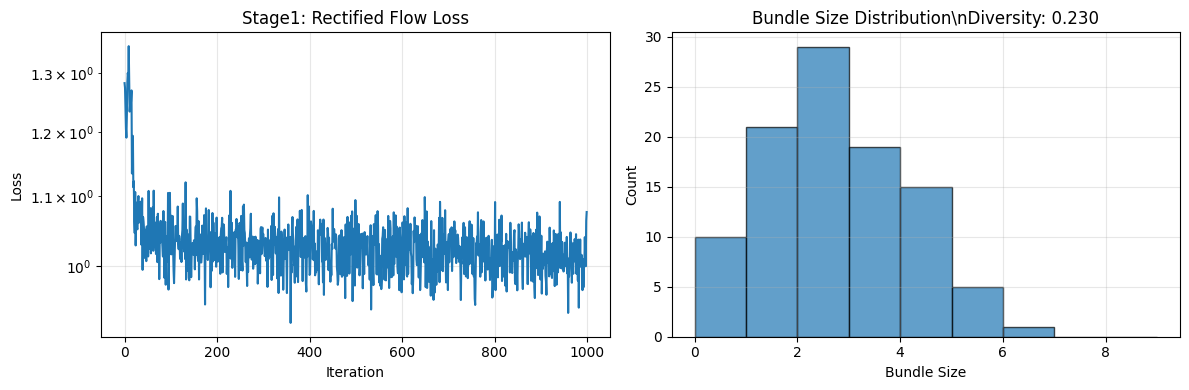

生成された束の多様性: 0.230 (59/256 ユニークな束)


In [37]:
plt.figure(figsize=(12, 4))

# 損失の推移
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Stage1: Rectified Flow Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# 束生成のテスト
plt.subplot(1, 2, 2)
with torch.no_grad():
    # ランダムな初期値から束を生成
    z = torch.randn(100, stage1_config['m'], device=device)
    t_grid = torch.linspace(0.0, 1.0, steps=stage1_config['ode_steps'], device=device)
    x_T = flow.flow_forward(z, t_grid)
    bundles = flow.round_to_bundle(x_T)

    # 束の多様性を計算
    unique_bundles = torch.unique(bundles, dim=0)
    diversity = len(unique_bundles) / (2 ** stage1_config['m'])

    # 束の分布を可視化
    bundle_sizes = bundles.sum(dim=1).cpu().numpy()
    plt.hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
    plt.title(f'Bundle Size Distribution\\nDiversity: {diversity:.3f}')
    plt.xlabel('Bundle Size')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"生成された束の多様性: {diversity:.3f} ({len(unique_bundles)}/{2**stage1_config['m']} ユニークな束)")

## 4. Stage2: Menu最適化

学習済みの速度場を使用して、メニュー要素（価格と初期分布）を最適化します。

In [38]:
# Stage2の設定（小規模でデモ用）
stage2_config = {
    'K': 16,           # メニュー要素数（小規模）
    'D': 4,            # 初期分布の混合成分数
    'iters': 500,      # イテレーション数（デモ用に短縮）
    'batch': 64,       # バッチサイズ
    'lr': 3e-1,        # 学習率
    'lam_start': 1e-3, # SoftMax温度の開始値
    'lam_end': 0.1,    # SoftMax温度の終了値
    'ode_steps': 25,   # ODE積分ステップ数
    'n_val': 200,      # 評価関数の数（小規模）
    'a': 8,            # XOR原子数（小規模）
    'seed': 123
}

print("Stage2設定:")
for key, value in stage2_config.items():
    print(f"  {key}: {value}")

Stage2設定:
  K: 16
  D: 4
  iters: 500
  batch: 64
  lr: 0.3
  lam_start: 0.001
  lam_end: 0.1
  ode_steps: 25
  n_val: 200
  a: 8
  seed: 123


In [39]:
# 評価関数データの生成
from bundleflow.data import gen_uniform_iid_xor

# 乱数固定
random.seed(stage2_config['seed'])
torch.manual_seed(stage2_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage2_config['seed'])

# 合成XOR評価関数を生成
valuations = []
for i in range(stage2_config['n_val']):
    val = gen_uniform_iid_xor(
        m=stage1_config['m'],
        a=stage2_config['a'],
        low=0.0,
        high=1.0,
        seed=1337 + i,
        atom_size_mode='small'
    )
    valuations.append(val)

print(f"✅ {len(valuations)}個の評価関数を生成しました")
print(f"最初の評価関数の原子数: {len(valuations[0].atoms)}")

# 評価関数の統計
atom_counts = [len(v.atoms) for v in valuations]
print(f"原子数の統計: min={min(atom_counts)}, max={max(atom_counts)}, mean={np.mean(atom_counts):.1f}")


✅ 200個の評価関数を生成しました
最初の評価関数の原子数: 8
原子数の統計: min=8, max=8, mean=8.0


In [40]:
# Stage2学習の実行
from bundleflow.models.menu import make_null_element, revenue_loss

# フローモデルを凍結（Stage1で学習済み）
for p in flow.parameters():
    p.requires_grad_(False)
flow.eval()

# メニュー要素の作成
menu = [MenuElement(m=stage1_config['m'], D=stage2_config['D']) for _ in range(stage2_config['K'])]
menu.append(make_null_element(stage1_config['m']))  # IR制約用のnull要素

# メニュー要素をデバイスに移動
for elem in menu:
    elem.to(device)

# オプティマイザー
all_params = []
for elem in menu:
    all_params.extend(elem.parameters())
optimizer = optim.Adam(all_params, lr=stage2_config['lr'])

print(f"🚀 Stage2学習開始 (device: {device})")
print(f"メニュー要素数: {len(menu)}")
print(f"学習パラメータ数: {sum(p.numel() for p in all_params):,}")

# 学習ループ
revenues = []
start_time = time.time()

for it in range(1, stage2_config['iters'] + 1):
    # バッチデータの準備
    batch_size = min(stage2_config['batch'], len(valuations))
    batch = random.sample(valuations, batch_size)

    # 温度スケジューリング
    lam = stage2_config['lam_start'] + (stage2_config['lam_end'] - stage2_config['lam_start']) * (it / stage2_config['iters'])

    # 時間グリッド
    t_grid = torch.linspace(0.0, 1.0, steps=stage2_config['ode_steps'], device=device)

    # 収益損失の計算
    loss = revenue_loss(flow, batch, menu, t_grid, lam=lam)

    # 最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 収益の記録（負の損失が収益）
    revenues.append(-loss.item())

    # 進捗表示
    if it % 50 == 0:
        elapsed = time.time() - start_time
        print(f"[{it}/{stage2_config['iters']}] Revenue: {revenues[-1]:.6f} λ: {lam:.4f} Time: {elapsed:.1f}s")

print(f"✅ Stage2学習完了! 最終収益: {revenues[-1]:.6f}")
print(f"総学習時間: {time.time() - start_time:.1f}秒")

🚀 Stage2学習開始 (device: cuda)
メニュー要素数: 17
学習パラメータ数: 602
[50/500] Revenue: 9.348436 λ: 0.0109 Time: 15.9s
[100/500] Revenue: 9.285476 λ: 0.0208 Time: 31.7s
[150/500] Revenue: 9.216940 λ: 0.0307 Time: 47.4s
[200/500] Revenue: 9.142439 λ: 0.0406 Time: 63.2s
[250/500] Revenue: 9.061568 λ: 0.0505 Time: 79.0s
[300/500] Revenue: 8.973931 λ: 0.0604 Time: 94.8s
[350/500] Revenue: 8.879120 λ: 0.0703 Time: 110.6s
[400/500] Revenue: 8.776744 λ: 0.0802 Time: 126.4s
[450/500] Revenue: 8.666419 λ: 0.0901 Time: 142.2s
[500/500] Revenue: 8.547792 λ: 0.1000 Time: 158.0s
✅ Stage2学習完了! 最終収益: 8.547792
総学習時間: 158.0秒


## 5. 結果の可視化

学習結果を可視化して、メニューの内容と性能を確認します。

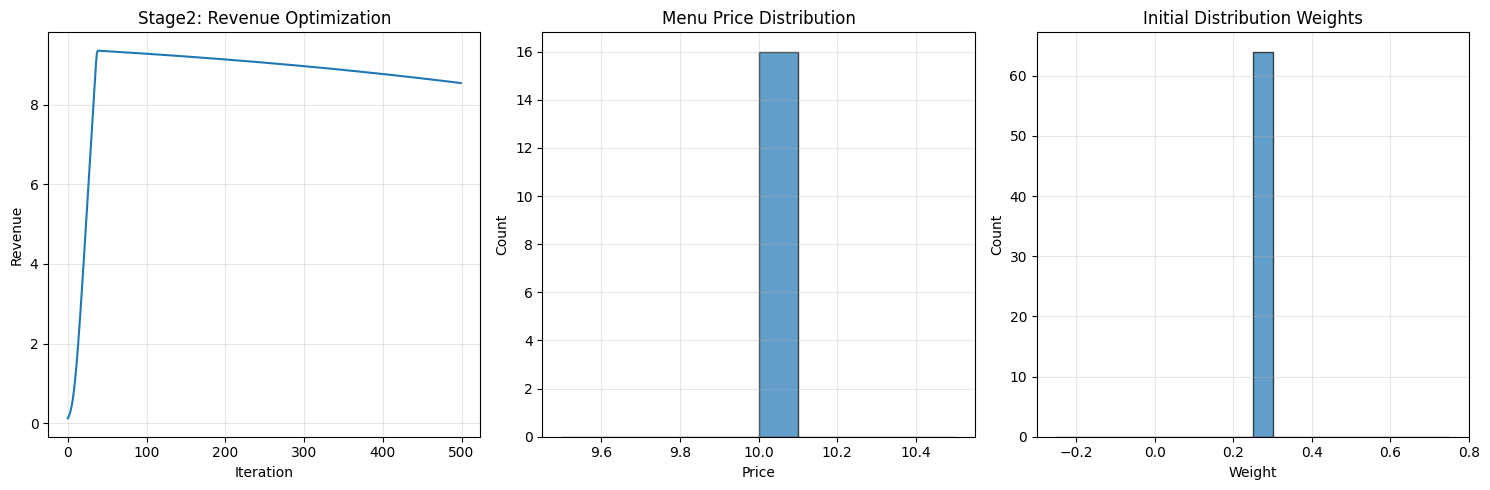

価格の統計: min=10.0000, max=10.0000, mean=10.0000


In [42]:
# Stage2の結果可視化
plt.figure(figsize=(15, 5))

# 収益の推移
plt.subplot(1, 3, 1)
plt.plot(revenues)
plt.title('Stage2: Revenue Optimization')
plt.xlabel('Iteration')
plt.ylabel('Revenue')
plt.grid(True, alpha=0.3)

# 価格の分布
plt.subplot(1, 3, 2)
prices = [elem.price().item() for elem in menu[:-1]]  # null要素を除く
plt.hist(prices, bins=10, alpha=0.7, edgecolor='black')
plt.title('Menu Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# メニュー要素の重み分布
plt.subplot(1, 3, 3)
weights = [elem.weights.cpu().detach().numpy() for elem in menu[:-1]] # .detach().numpy() を追加
weights_flat = np.concatenate(weights)
plt.hist(weights_flat, bins=20, alpha=0.7, edgecolor='black')
plt.title('Initial Distribution Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"価格の統計: min={min(prices):.4f}, max={max(prices):.4f}, mean={np.mean(prices):.4f}")

In [43]:
# メニューの詳細分析
from bundleflow.models.menu import visualize_menu

# メニューの可視化
t_grid = torch.linspace(0.0, 1.0, steps=stage2_config['ode_steps'], device=device)
visualize_menu(flow, menu, t_grid, max_items=8, device=device)

# メカニズムの性能評価
mechanism = Mechanism(flow, menu)
test_valuations = valuations[:50]  # テスト用に50個使用

# 期待収入の計算
expected_revenue = mechanism.expected_revenue(test_valuations)
print(f"\\n📊 性能評価:")
print(f"期待収入: {expected_revenue.item():.4f}")

# ハード割当での結果
result = mechanism.argmax_menu(test_valuations)
print(f"ハード割当収入: {result['revenue'].item():.4f}")
print(f"平均効用: {result['welfare'].item():.4f}")
print(f"IR制約満足率: {result['ir_satisfied'].item():.4f}")


📋 MENU VISUALIZATION (showing first 8 items)

🍽️  Menu Item 1: Price = 10.0000
   📦 Generated bundles (1 unique):
      1. [Empty bundle]

🍽️  Menu Item 2: Price = 10.0000
   📦 Generated bundles (1 unique):
      1. [Empty bundle]

🍽️  Menu Item 3: Price = 10.0000
   📦 Generated bundles (1 unique):
      1. [Empty bundle]

🍽️  Menu Item 4: Price = 10.0000
   📦 Generated bundles (1 unique):
      1. [Empty bundle]

🍽️  Menu Item 5: Price = 10.0000
   📦 Generated bundles (1 unique):
      1. [Empty bundle]

🍽️  Menu Item 6: Price = 10.0000
   📦 Generated bundles (1 unique):
      1. [Empty bundle]

🍽️  Menu Item 7: Price = 10.0000
   📦 Generated bundles (1 unique):
      1. [Empty bundle]

🍽️  Menu Item 8: Price = 10.0000
   📦 Generated bundles (1 unique):
      1. [Empty bundle]

... and 9 more menu items

\n📊 性能評価:
期待収入: 8.5478
ハード割当収入: 0.0000
平均効用: 0.0000
IR制約満足率: 1.0000


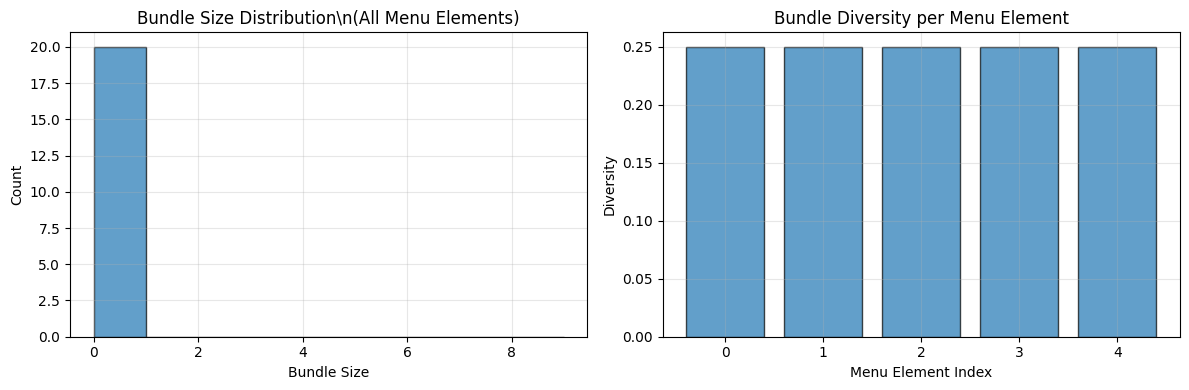

束サイズの統計: min=0.0, max=0.0, mean=0.0
多様性の統計: min=0.250, max=0.250, mean=0.250


In [44]:
plt.figure(figsize=(12, 4))

# 各メニュー要素から生成される束の分析
bundle_sizes = []
bundle_diversities = []

with torch.no_grad():
    for i, elem in enumerate(menu[:5]):  # 最初の5要素を分析
        # 束生成
        s_T = flow.flow_forward(elem.mus, t_grid)
        bundles = flow.round_to_bundle(s_T)

        # 束サイズの分布
        sizes = bundles.sum(dim=1).cpu().numpy()
        bundle_sizes.extend(sizes)

        # 多様性
        unique_bundles = torch.unique(bundles, dim=0)
        diversity = len(unique_bundles) / bundles.shape[0]
        bundle_diversities.append(diversity)

# 束サイズの分布
plt.subplot(1, 2, 1)
plt.hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
plt.title('Bundle Size Distribution\\n(All Menu Elements)')
plt.xlabel('Bundle Size')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# 多様性の分布
plt.subplot(1, 2, 2)
plt.bar(range(len(bundle_diversities)), bundle_diversities, alpha=0.7, edgecolor='black')
plt.title('Bundle Diversity per Menu Element')
plt.xlabel('Menu Element Index')
plt.ylabel('Diversity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"束サイズの統計: min={min(bundle_sizes)}, max={max(bundle_sizes)}, mean={np.mean(bundle_sizes):.1f}")
print(f"多様性の統計: min={min(bundle_diversities):.3f}, max={max(bundle_diversities):.3f}, mean={np.mean(bundle_diversities):.3f}")


## 🎉 まとめ

このデモンストレーションでは、BundleFlowの新しいAPI構造を使用して、組み合わせオークションのためのメニュー最適化を実行しました。

### 実行した内容
1. **環境セットアップ**: GPU環境の確認とパッケージインストール
2. **新しいAPI構造のデモ**: BundleFlow、MenuElement、XORValuationの基本機能
3. **Stage1学習**: 速度場ネットワークの学習（連続→離散変換）
4. **Stage2学習**: メニュー要素の最適化（価格と初期分布）
5. **結果可視化**: 学習結果とメニュー性能の分析

### 新しいAPI構造の利点
- **明確な責務分離**: 速度場、メニュー要素、評価関数が独立
- **型安全性**: 完全な型注釈とdocstring
- **経済学的記号**: 論文と一致した記号体系
- **後方互換性**: 既存コードも動作

### 次のステップ
- より大きな問題サイズでの実験
- 異なる評価関数分布での性能比較
- ハイパーパラメータの最適化
- 実際のオークションデータでの検証

---

**📚 詳細な情報**: [MODEL.md](MODEL.md) - モデル記号と目的のドキュメント
